<img src="images/MapleStory.SVG" align="right" width=30%>
# VAE for MapleStory Character Generation
Author: Jin Yeom (jinyeom@utexas.edu)

## Contents
- [Data collection](#Data-collection)
- [Dataset](#Dataset)

In this notebook, we're going to build a **variational autoencoder** (VAE) model for generating [MapleStory](http://maplestory.nexon.net/landing/) characters. There wasn't any particular reason for the choice of data (I did collect the dataset myself, thinking it would be cool to be able to generate MapleStory characters), but the main goal of this project is to learn how VAE works as a generative model.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm_notebook as tqdm
from PIL import Image

## Data collection

I won't share the images that I collected, as they are not mine, but I seemed to have accidentally left the script below that scrapes the same webpages. How careless of me.

In [ ]:
# NOTE: do NOT run this script unless it's necessary!

import time
from datetime import datetime
import pathlib
from uuid import uuid4
from urllib.request import Request, urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

try:
    # mkdir datasets/maple-vae if it doesn't exist yet
    pathlib.Path("datasets/maplestory").mkdir(parents=True)
except FileExistsError:
    print("datasets/maplestory already exists, moving on...")

# URL template for scraping MapleStory avatars from the ranking page
url_tmpl = ("http://maplestory.nexon.net/rankings/overall-ranking/"
            "legendary?rebootIndex=0&pageIndex={}#ranking")
for page_index in tqdm(range(1, 50000, 5)):
    url = url_tmpl.format(page_index)
    req = Request(url, headers={"User-Agent": "Mozilla/5.0"}) # pretend you're human!
    soup = BeautifulSoup(urlopen(req), "html.parser")
    for av in soup.find_all("img", {"class": "avatar"}):
        for i in range(5): # try 5 times
            img_req = Request(av["src"], headers={"User-Agent": "Mozilla/5.0"})
            try:
                img = urlopen(img_req).read()
                with open(f"datasets/maplestory/{uuid4().hex}.png", "wb") as f:
                    f.write(img)
                break
            except ConnectionError:
                now = datetime.now()
                print(f"[{now}] Connection error, retrying in 3 seconds...", flush=True)
                time.sleep(3)
            except HTTPError:
                now = datetime.now()
                print(f"[{now}] HTTP error, skipping...", flush=True)
                break
        else:
            raise
    if page_index % 500 == 0:
        time.sleep(5)

Now, let's separate the dataset into a train set and a test set! Note that each file name is assigned randomly, and we will iterate through them in order of their names. I think it's safe to assume that there is no bias in how we separate the test set from the train set.

In [18]:
%%bash

mkdir -p datasets/maplestory/train
mkdir -p datasets/maplestory/test

i=0
for f in datasets/maplestory/*.png; do
    if (($i < 40000)); then
        mv $f datasets/maplestory/train/
    else
        mv $f datasets/maplestory/test/
    fi
    i=$((i + 1))
done

ls datasets/maplestory/train | wc -l
ls datasets/maplestory/test | wc -l

40000
10000


## Dataset

In [38]:
class MapleDataset(data.Dataset):
    def __init__(self, root, transform, mode="train"):
        self.transform = transform
        self._images = sorted(glob(f"{root}/{mode}/*.png"))
        
    def __len__(self):
        return len(self._images)
    
    def __getitem__(self, index):
        img = Image.open(self._images[index])
        pix = np.array(img)
        alpha = pix[:, :, 3] # alpha channel
        pix[alpha == 0.0] = 255 # whiten the transparent parts
        img = Image.fromarray(pix[:, :, :3], "RGB")
        return self.transform(img)

In [39]:
def get_loaders(root, transform, batch_size, num_workers=2):
    train_set = MapleDataset(root, transform=transform, mode="train")
    test_set = MapleDataset(root, transform=transform, mode="test")
    
    train_loader = data.DataLoader(train_set,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   num_workers=num_workers)
    test_loader = data.DataLoader(test_set,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=1)
    return train_loader, test_loader

Let's take a look at some samples!

In [55]:
def imshow(img, title, figsize=(12, 12)):
    img = img / 2 + 0.5
    npimg = img.detach().numpy()
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

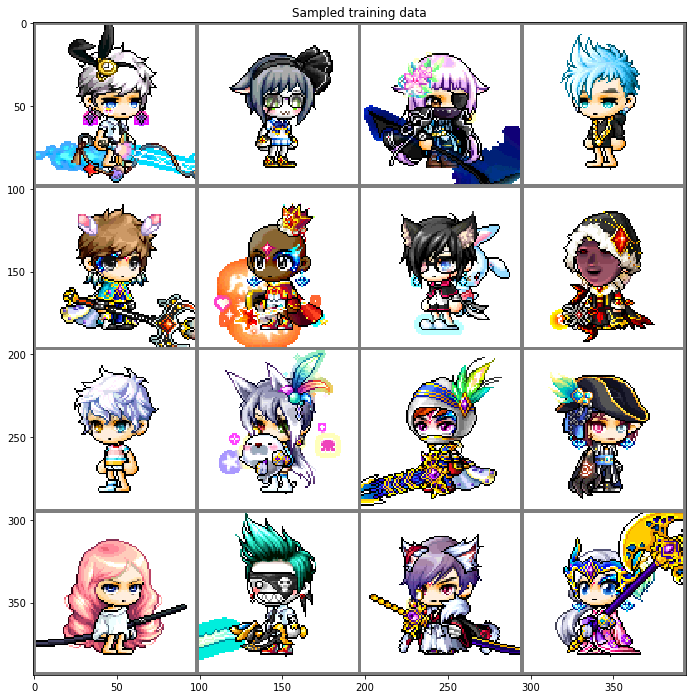

In [56]:
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_loader, test_loader = get_loaders("datasets/maplestory", transform, 16)

images = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, nrow=4), "Sampled training data")

## Model

![VAE](images/VAE.png)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 4, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, stride=2, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        
    def forward(self, x):
        # TODO: implement
        raise NotImplementedError

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
    def forward(self, x):
        # TODO: implement
        raise NotImplementedError

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def reparam(self, mu, logvar):
        # TODO: implement
        raise NotImplementedError
        
    def forward(self, x):
        # TODO: implement
        raise NotImplementedError